# KG Normalization Analysis — Cosine vs Levenshtein

Compare cosine (embedding) and levenshtein (string) similarity as candidate-finding metrics for entity merging.
Data exported from `kg_experiment_v2.ipynb` with both metrics tracked for every candidate pair.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [38]:
df_llm_1 = pd.read_csv(Path("llm_normalization_results_cos_and_lev.csv"))
df_llm_2 = pd.read_csv(Path("llm_normalization_results_cos_and_lev_2.csv"))
df_llm = pd.concat([df_llm_1, df_llm_2], ignore_index=True)

In [39]:

print(f"Loaded {len(df_llm)} LLM check results")
print(f"  Merges: {df_llm['should_merge'].sum()}, Non-merges: {(~df_llm['should_merge']).sum()}")
print(f"  Cosine range:      {df_llm['cosine_similarity'].min():.3f} - {df_llm['cosine_similarity'].max():.3f}")
print(f"  Levenshtein range: {df_llm['levenshtein_similarity'].min():.3f} - {df_llm['levenshtein_similarity'].max():.3f}")

Loaded 379 LLM check results
  Merges: 39, Non-merges: 340
  Cosine range:      0.224 - 0.862
  Levenshtein range: 0.000 - 0.923


In [40]:
# Summary stats split by merge decision
merges = df_llm[df_llm["should_merge"]]
non_merges = df_llm[~df_llm["should_merge"]]

print(f"Total: {len(df_llm)} checks ({len(merges)} merges, {len(non_merges)} non-merges)\n")

for metric in ["cosine_similarity", "levenshtein_similarity"]:
    print(f"--- {metric} ---")
    if not merges.empty:
        print(f"  Merges:     min={merges[metric].min():.3f}, max={merges[metric].max():.3f}, mean={merges[metric].mean():.3f}")
    print(f"  Non-merges: min={non_merges[metric].min():.3f}, max={non_merges[metric].max():.3f}, mean={non_merges[metric].mean():.3f}")
    print()

Total: 379 checks (39 merges, 340 non-merges)

--- cosine_similarity ---
  Merges:     min=0.484, max=0.862, mean=0.753
  Non-merges: min=0.224, max=0.835, mean=0.662

--- levenshtein_similarity ---
  Merges:     min=0.000, max=0.923, mean=0.571
  Non-merges: min=0.000, max=0.867, mean=0.462



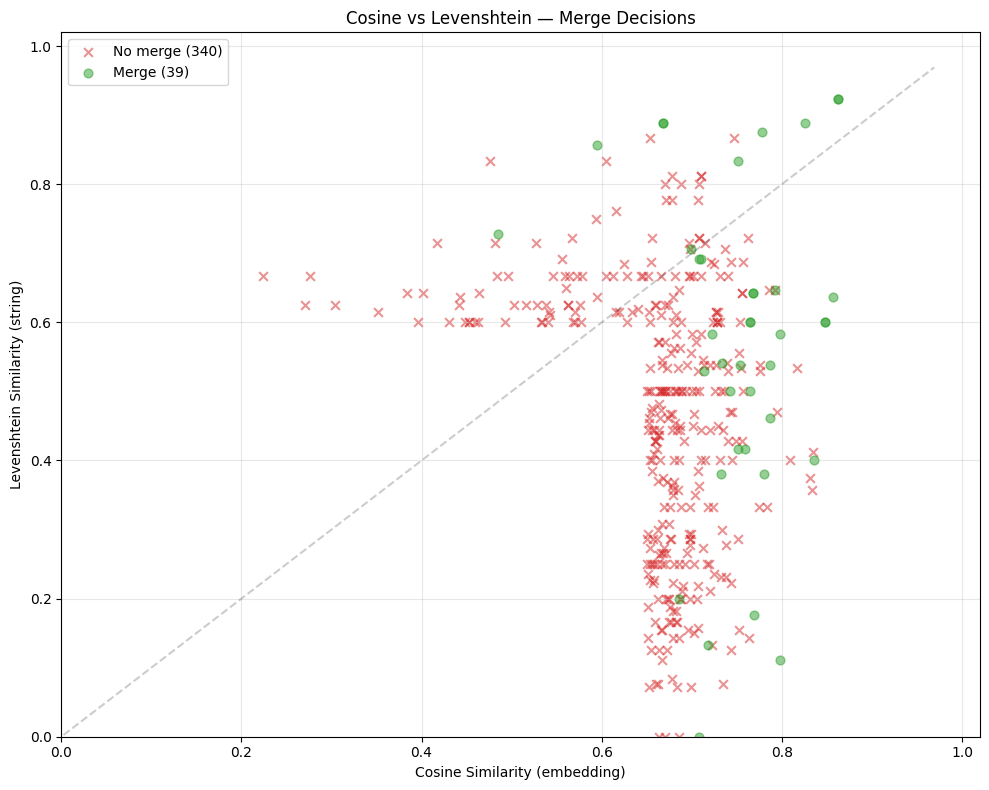

In [42]:
# Scatter: cosine vs levenshtein, colored by merge decision
fig, ax = plt.subplots(figsize=(10, 8))

for label, color, marker in [(False, "#d62728", "x"), (True, "#2ca02c", "o")]:
    subset = df_llm[df_llm["should_merge"] == label]
    ax.scatter(
        subset["cosine_similarity"], subset["levenshtein_similarity"],
        c=color, marker=marker, alpha=0.5, s=40,
        label=f"{'Merge' if label else 'No merge'} ({len(subset)})",
    )

ax.set_xlabel("Cosine Similarity (embedding)")
ax.set_ylabel("Levenshtein Similarity (string)")
ax.set_title("Cosine vs Levenshtein — Merge Decisions")
ax.legend()
ax.grid(True, alpha=0.3)
# ax.set_xlim(0.65, None)

# Diagonal reference line (equal scores)
lims = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
ax.plot(lims, lims, "k--", alpha=0.2, label="y=x")
ax.set_xlim(0.0, None)
ax.set_ylim(0.0, None)

plt.tight_layout()
plt.show()

In [43]:
# Combined score: max(cosine, levenshtein) — does combining help?
df_llm["combined_max"] = df_llm[["cosine_similarity", "levenshtein_similarity"]].max(axis=1)
df_llm["combined_mean"] = df_llm[["cosine_similarity", "levenshtein_similarity"]].mean(axis=1)

print("Correlation with should_merge:")
for metric in ["cosine_similarity", "levenshtein_similarity", "combined_max", "combined_mean"]:
    corr = df_llm[metric].corr(df_llm["should_merge"].astype(float))
    print(f"  {metric:25s}: {corr:.3f}")

Correlation with should_merge:
  cosine_similarity        : 0.306
  levenshtein_similarity   : 0.164
  combined_max             : 0.496
  combined_mean            : 0.298


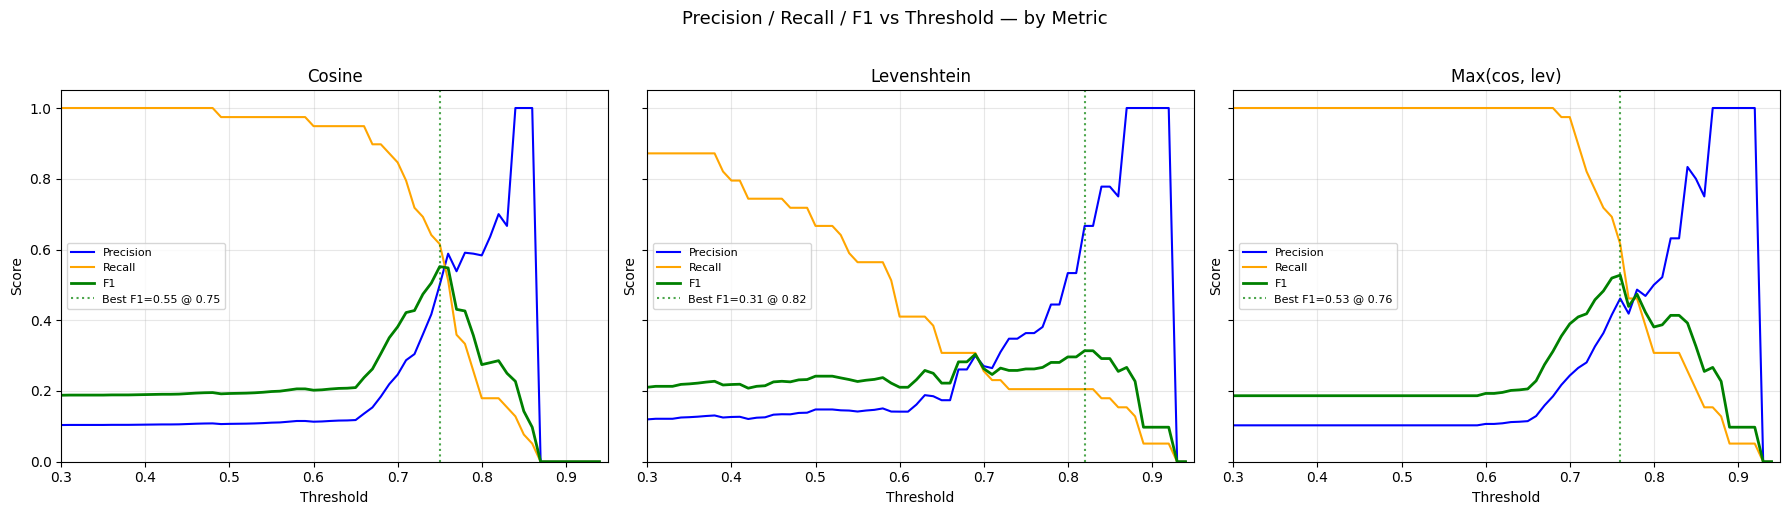

In [44]:
# Precision / Recall / F1 curves for each metric
# Treating LLM should_merge as ground truth:
#   At threshold t: candidates = pairs with score >= t
#   TP = merges above t, FP = non-merges above t, FN = merges below t

metrics = {
    "cosine_similarity": "Cosine",
    "levenshtein_similarity": "Levenshtein",
    "combined_max": "Max(cos, lev)",
}

fig, axes = plt.subplots(1, len(metrics), figsize=(6 * len(metrics), 5), sharey=True)
total_merges = df_llm["should_merge"].sum()

for ax, (col, label) in zip(axes, metrics.items()):
    thresholds = np.arange(0.30, 0.95, 0.01)
    precision, recall, f1 = [], [], []

    for t in thresholds:
        above = df_llm[df_llm[col] >= t]
        tp = above["should_merge"].sum()
        fp = len(above) - tp
        fn = total_merges - tp
        p = tp / (tp + fp) if (tp + fp) > 0 else 0
        r = tp / (tp + fn) if (tp + fn) > 0 else 0
        f = 2 * p * r / (p + r) if (p + r) > 0 else 0
        precision.append(p)
        recall.append(r)
        f1.append(f)

    ax.plot(thresholds, precision, label="Precision", color="blue")
    ax.plot(thresholds, recall, label="Recall", color="orange")
    ax.plot(thresholds, f1, label="F1", color="green", linewidth=2)

    best_idx = np.argmax(f1)
    ax.axvline(thresholds[best_idx], color="green", linestyle=":", alpha=0.7,
               label=f"Best F1={f1[best_idx]:.2f} @ {thresholds[best_idx]:.2f}")

    ax.set_xlabel("Threshold")
    ax.set_ylabel("Score")
    ax.set_title(f"{label}")
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0.30, 0.95)
    ax.set_ylim(0, 1.05)

fig.suptitle("Precision / Recall / F1 vs Threshold — by Metric", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

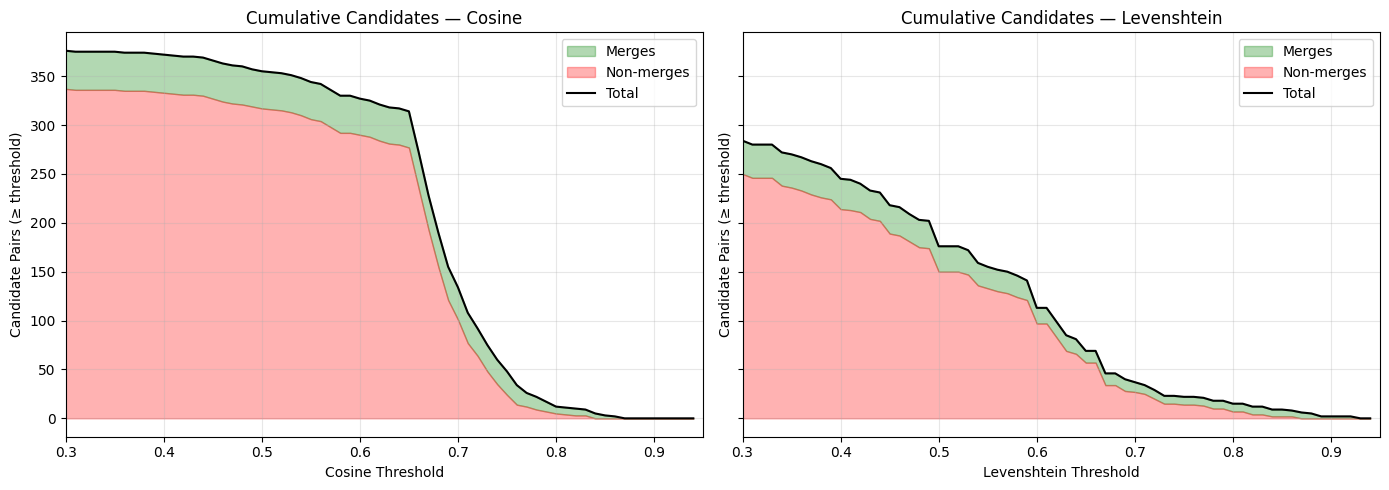

In [45]:
# Cumulative candidate counts vs threshold — both metrics side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

for ax, (col, label) in zip(axes, [("cosine_similarity", "Cosine"), ("levenshtein_similarity", "Levenshtein")]):
    thresholds_cum = np.arange(0.30, 0.95, 0.01)
    counts_all = [len(df_llm[df_llm[col] >= t]) for t in thresholds_cum]
    counts_merge = [df_llm.loc[df_llm[col] >= t, "should_merge"].sum() for t in thresholds_cum]
    counts_no_merge = [c - m for c, m in zip(counts_all, counts_merge)]

    ax.fill_between(thresholds_cum, counts_no_merge, counts_all, alpha=0.3, color="green", label="Merges")
    ax.fill_between(thresholds_cum, 0, counts_no_merge, alpha=0.3, color="red", label="Non-merges")
    ax.plot(thresholds_cum, counts_all, color="black", linewidth=1.5, label="Total")

    ax.set_xlabel(f"{label} Threshold")
    ax.set_ylabel("Candidate Pairs (\u2265 threshold)")
    ax.set_title(f"Cumulative Candidates — {label}")
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0.30, 0.95)

plt.tight_layout()
plt.show()

In [46]:
len(df_llm)

379

In [47]:
df_llm["should_merge"].sum()

np.int64(39)

In [51]:
# Merges sorted by combined_max — see which metric "found" each merge
df_llm[df_llm["should_merge"]].sort_values("cosine_similarity", ascending=False)[
    ["entity1_name", "entity2_name", "cosine_similarity", "levenshtein_similarity", "combined_max"]
]

,entity1_name,entity2_name,cosine_similarity,levenshtein_similarity,combined_max
303,Carthaginian,Carthaginians,0.862352,0.923077,0.923077
102,Carthaginian,Carthaginians,0.862310,0.923077,0.923077
37,consuls,Two consuls,0.857046,0.636364,0.857046
306,provinces,Roman provinces,0.848257,0.600000,0.848257
103,provinces,Roman provinces,0.847970,0.600000,0.847970
104,Roman army,Roman military power,0.835793,0.400000,0.835793
281,Etruscan,Etruscans,0.825473,0.888889,0.888889
158,barbarian invaders,Gauls,0.798191,0.111111,0.798191
187,Roman rule,Roman Empire,0.797747,0.583333,0.797747
355,Greek background,Greek influence,0.792578,0.647059,0.792578


In [ ]:
# Non-merge sample — sorted by combined_max descending to see hardest negatives
df_llm[~df_llm["should_merge"]].sort_values("combined_max", ascending=False).head(20)[
    ["entity1_name", "entity2_name", "cosine_similarity", "levenshtein_similarity", "combined_max"]
]

,entity1_name,entity2_name,cosine_similarity,levenshtein_similarity,combined_max
247,Roman proletariat,Romans,0.834839,0.411765,0.834839
214,Rhine frontier,Rhine,0.833246,0.357143,0.833246
154,senatorial power,Roman Senate,0.831361,0.375000,0.831361
185,Roman rule,Roman provinces,0.816429,0.533333,0.816429
186,Roman rule,Roman army,0.809409,0.400000,0.809409
273,Egyptian gods,Roman (Graeco-Roman) pantheon,0.794126,0.470588,0.794126
230,Greek background,Hellenization,0.792571,0.647059,0.792571
87,second century BC,fifth century BC,0.785970,0.647059,0.785970
221,Greeks of the Hellenistic era,Greeks,0.783807,0.333333,0.783807
222,first century AD,second century BC,0.775940,0.529412,0.775940
